In [29]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

from pathlib import Path
from dataclasses import dataclass


from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
import numpy as np
import cv2

In [30]:
mp_drawing = mp.solutions.drawing_utils     # import mediapipe drawing utils
mp_styles = mp.solutions.drawing_styles     # import mediapipe drawing styles

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [31]:
def get_landmarker_results_from_video(
    video_path, options, start_time_ms=None, end_time_ms=None
):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"{fps=}")
    if start_time_ms:
        cap.set(cv2.CAP_PROP_POS_MSEC, start_time_ms)
    pose_landmarker_results = []
    landmarker = mp.tasks.vision.PoseLandmarker.create_from_options(
        options
    )
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Can't read frame. Skipping...")
            break
        curr_frame_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        if end_time_ms and curr_frame_timestamp_ms >= end_time_ms:
            break
        downscaled_frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(downscaled_frame, cv2.COLOR_BGR2RGB),
        )
        pose_landmarker_result = landmarker.detect_for_video(
            mp_image, int(cap.get(cv2.CAP_PROP_POS_MSEC))
        )
        pose_landmarker_results.append(
            {
                "timestamp_ms": curr_frame_timestamp_ms,
                "original_frame": downscaled_frame,
                "landmarker_results": pose_landmarker_result,
            }
        )
    cap.release()
    return pose_landmarker_results

In [32]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for pose_landmarks in pose_landmarks_list:
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for idx, landmark in enumerate(pose_landmarks)
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

In [33]:
model_path = "assets/pose_landmarker_heavy.task"
model_path = "assets/pose_landmarker_lite.task"
video_path = "media/realspeed/Jab-12seconds.mp4"
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True,
)
pose_landmarker_results = get_landmarker_results_from_video(
    video_path, options, end_time_ms=25 * 1e3
)

fps=29.99705455278293


c:\Users\adware\Desktop\boxing_dynamics\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Can't read frame. Skipping...


In [34]:
first_frame = pose_landmarker_results[0]["original_frame"]
height, width, _ = first_frame.shape
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
out = cv2.VideoWriter(
    "media/annotated/hook.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width * 2, height),  # width doubled for side-by-side
)


for frame_data in pose_landmarker_results:
    original_frame = cv2.cvtColor(
        frame_data["original_frame"], cv2.COLOR_BGR2RGB
    )
    landmarks_frame = np.copy(original_frame)
    alpha = 0.5
    landmarks_frame = cv2.addWeighted(
        landmarks_frame,
        alpha,
        np.zeros_like(landmarks_frame),
        1 - alpha,
        0,
    )
    landmarks_frame = draw_landmarks_on_image(
        landmarks_frame, frame_data["landmarker_results"]
    )
    landmarkers = frame_data["landmarker_results"]
    # height, width, _ = landmarks_frame.shape
    # force_x_img, force_y_img = (
    #     int(landmarkers.pose_landmarks[0][25].x * width),
    #     int(landmarkers.pose_landmarks[0][25].y * height),
    # )
    # cv2.arrowedLine(
    #     landmarks_frame,
    #     pt1=(force_x_img, force_y_img),
    #     pt2=(force_x_img + 50, force_y_img),
    #     color=(255, 0, 0),
    #     thickness=4,
    # )
    # force_x_img, force_y_img = (
    #     int(landmarkers.pose_landmarks[0][30].x * width),
    #     int(landmarkers.pose_landmarks[0][30].y * height),
    # )
    # cv2.arrowedLine(
    #     landmarks_frame,
    #     pt1=(force_x_img, force_y_img),
    #     pt2=(force_x_img, force_y_img - 50),
    #     color=(255, 0, 0),
    #     thickness=4,
    # )

    # force_x_img, force_y_img = (
    #     int(landmarkers.pose_landmarks[0][29].x * width),
    #     int(landmarkers.pose_landmarks[0][29].y * height),
    # )
    # cv2.arrowedLine(
    #     landmarks_frame,
    #     pt1=(force_x_img, force_y_img),
    #     pt2=(force_x_img, force_y_img + 50),
    #     color=(255, 0, 0),
    #     thickness=4,
    # )

    side_by_side = np.concatenate(
        (original_frame, landmarks_frame), axis=1
    )

    side_by_side_bgr = cv2.cvtColor(side_by_side, cv2.COLOR_RGB2BGR)
    out.write(side_by_side_bgr)
out.release()

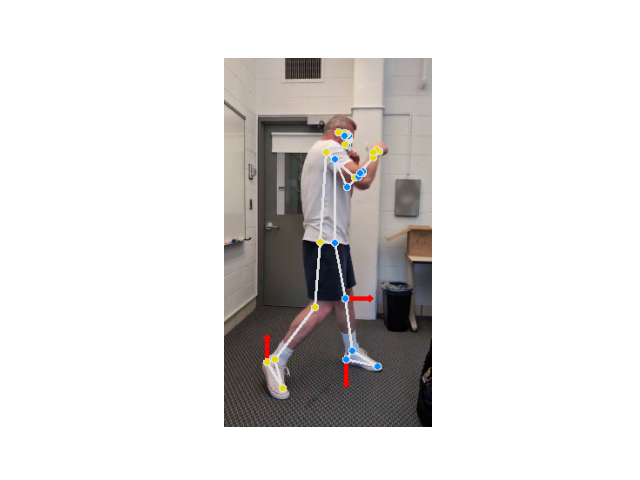

In [35]:
frame_idx = 155
landmarkers = pose_landmarker_results[frame_idx]["landmarker_results"]
original_frame_bgr = pose_landmarker_results[frame_idx][
    "original_frame"
].copy()
height, width, _ = original_frame_bgr.shape
force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][25].x * width),
    int(landmarkers.pose_landmarks[0][25].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img + 30, force_y_img),
    color=(0, 0, 255),
    thickness=4,
)
force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][30].x * width),
    int(landmarkers.pose_landmarks[0][30].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img, force_y_img - 30),
    color=(0, 0, 255),
    thickness=4,
)

force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][29].x * width),
    int(landmarkers.pose_landmarks[0][29].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img, force_y_img + 30),
    color=(0, 0, 255),
    thickness=4,
)

original_frame_rgb = cv2.cvtColor(
    original_frame_bgr, cv2.COLOR_BGR2RGB
)
annotated_frame = draw_landmarks_on_image(
    original_frame_rgb,
    landmarkers,
)
plt.close("all")
plt.imshow(annotated_frame)
plt.axis("off")  # hide axes
plt.show()

In [36]:
from matplotlib.animation import FuncAnimation
from mediapipe.python.solutions import pose as mp_pose

In [37]:
def get_3d_pose_human_frame_for_keypoint(
    pose_world_landmarkers, keypoint: mp_pose.PoseLandmark
):
    return np.array(
        [
            pose_world_landmarkers[keypoint].x,
            pose_world_landmarkers[keypoint].y,
            pose_world_landmarkers[keypoint].z,
        ]
    )

In [38]:
def draw_3d_pose_human_frame(pose_landmarker_result, ax):
    pose_world_landmarkers = pose_landmarker_result["landmarker_results"].pose_world_landmarks[0]

    x = np.array(
        [
            lm.x
            for lm in pose_world_landmarkers
            if lm != mp_pose.PoseLandmark.LEFT_KNEE
            and lm != mp_pose.PoseLandmark.RIGHT_KNEE
        ]
    )
    y = np.array(
        [
            lm.y
            for lm in pose_world_landmarkers
            if lm != mp_pose.PoseLandmark.LEFT_KNEE
            and lm != mp_pose.PoseLandmark.RIGHT_KNEE
        ]
    )
    z = np.array(
        [
            lm.z
            for lm in pose_world_landmarkers
            if lm != mp_pose.PoseLandmark.LEFT_KNEE
            and lm != mp_pose.PoseLandmark.RIGHT_KNEE
        ]
    )

    ax.scatter(x, z, y, s=20, c="magenta")

    left_knee = get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, mp_pose.PoseLandmark.LEFT_KNEE
    )
    right_knee = get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, mp_pose.PoseLandmark.RIGHT_KNEE
    )
    ax.scatter(
        left_knee[0],
        left_knee[2],
        left_knee[1],
        marker="*",
        s=60,
        color="blue",
    )
    ax.scatter(
        right_knee[0],
        right_knee[2],
        right_knee[1],
        marker="*",
        s=60,
        color="blue",
    )

    for connection in mp_pose.POSE_CONNECTIONS:
        start, end = connection
        ax.plot(
            [x[start], x[end]],
            [z[start], z[end]],
            [y[start], y[end]],
            color="indigo",
        )

    left_hip = get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, mp_pose.PoseLandmark.LEFT_HIP
    )
    right_hip = get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, mp_pose.PoseLandmark.RIGHT_HIP
    )
    hip_mid = (left_hip + right_hip) / 2.0
    ax.scatter(
        hip_mid[0],
        hip_mid[2],
        hip_mid[1],
        c="green",
        marker="*",
        s=100,
        label="human frame origin",
    )

    ax.quiver(
        *hip_mid,
        1,
        0,
        0,
        color="red",
        alpha=0.5,
        linewidth=3,
        arrow_length_ratio=0.4,
    )
    ax.quiver(
        *hip_mid,
        0,
        1,
        0,
        color="green",
        alpha=0.5,
        linewidth=3,
        arrow_length_ratio=0.4,
    )
    ax.quiver(
        *hip_mid,
        0,
        0,
        1,
        color="blue",
        alpha=0.5,
        linewidth=3,
        arrow_length_ratio=0.4,
    )

    ax.set(
        xlabel="x - human",
        ylabel="z - human",
        zlabel="y - human",
    )
    ax.legend(loc="lower left")
    lim = 0.75
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim])
    ax.invert_zaxis()

In [39]:
def calculate_nominal_joint_angle(proximal_vec, distal_vec):
    similarity = np.dot(proximal_vec, distal_vec) / (
        np.linalg.norm(proximal_vec) * np.linalg.norm(distal_vec)
    )
    return np.arccos(similarity)

In [40]:
def calculate_left_right_knee_flexion(pose_landmarker_result):
    pose_world_landmarkers = pose_landmarker_result[
        "landmarker_results"
    ].pose_world_landmarks[0]

    get_limb_vector = lambda proximal_kp, distal_kp: get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, proximal_kp
    ) - get_3d_pose_human_frame_for_keypoint(
        pose_world_landmarkers, distal_kp
    )

    # shank
    left_shank = get_limb_vector(
        mp_pose.PoseLandmark.LEFT_KNEE,
        mp_pose.PoseLandmark.LEFT_ANKLE,
    )
    right_shank = get_limb_vector(
        mp_pose.PoseLandmark.RIGHT_KNEE,
        mp_pose.PoseLandmark.RIGHT_ANKLE,
    )

    # thigh
    left_thigh = get_limb_vector(
        mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_HIP
    )
    right_thigh = get_limb_vector(
        mp_pose.PoseLandmark.RIGHT_KNEE,
        mp_pose.PoseLandmark.RIGHT_HIP,
    )

    left_knee_flex_angle = calculate_nominal_joint_angle(
        left_thigh, left_shank
    )
    right_knee_flex_angle = calculate_nominal_joint_angle(
        right_thigh, right_shank
    )
    return np.rad2deg(
        np.array([left_knee_flex_angle, right_knee_flex_angle])
    )

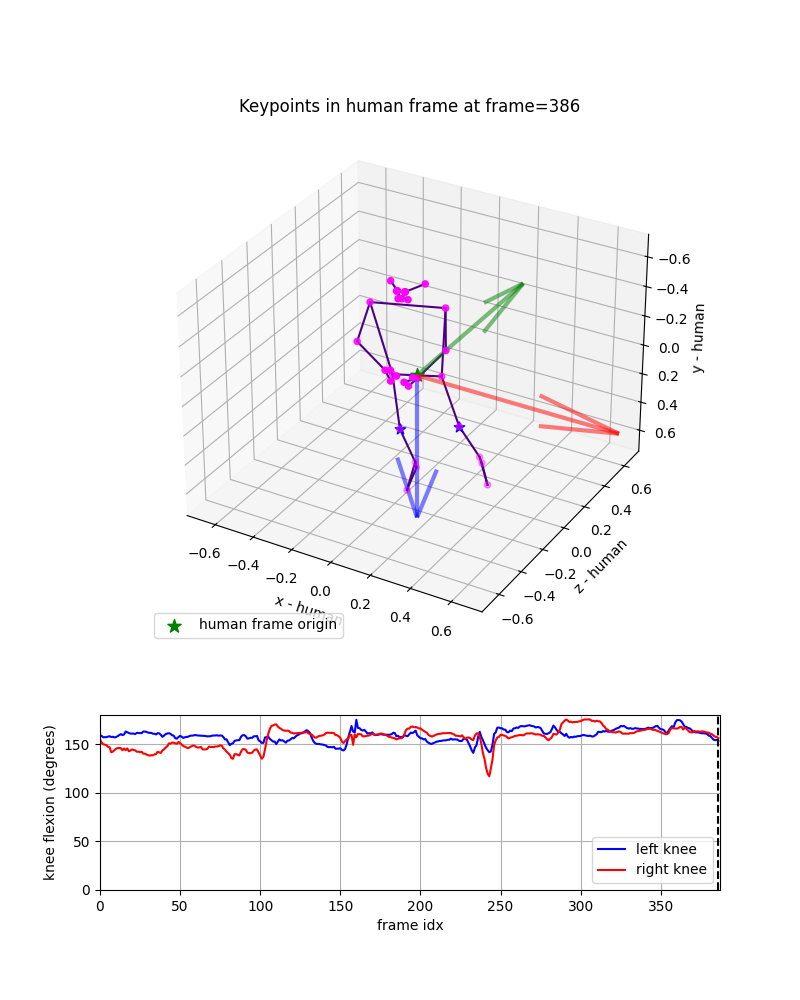

In [41]:
plt.close("all")
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])
num_frames = len(pose_landmarker_results)

ax2.set(
    xlim=(0, num_frames),
    ylim=(0, 180),
    xlabel="frame idx",
    ylabel="knee flexion (degrees)",
)


left_angles = []
right_angles = []
for result in pose_landmarker_results[:num_frames]:
    left_knee_angle, right_knee_angle = (
        calculate_left_right_knee_flexion(result)
    )
    left_angles.append(left_knee_angle)
    right_angles.append(right_knee_angle)

ax2.plot(range(num_frames), left_angles, color="b", label="left knee")
ax2.plot(
    range(num_frames), right_angles, color="r", label="right knee"
)
ax2.grid(True)
ax2.legend(loc="lower right")

cursor_line = ax2.axvline(0, color="k", linestyle="--")


def update(frame_idx):
    ax1.cla()
    draw_3d_pose_human_frame(pose_landmarker_results[frame_idx], ax1)
    ax1.set_title(f"Keypoints in human frame at frame={frame_idx}")
    cursor_line.set_xdata([frame_idx])


anim = FuncAnimation(
    fig,
    update,
    frames=num_frames,
    interval=50,
)

# anim.save("pose_animation.mp4", writer="ffmpeg", fps=15)
anim.save("pose_animation.gif", writer="pillow", fps=15)